In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.mobile_optimizer import optimize_for_mobile

In [ ]:
df = pd.read_csv('sample_data/final_df_activity_v2.csv')
df

,gyro_x,gyro_y,gyro_z,acceleration_x,acceleration_y,acceleration_z,target
0,181,-3007,2892,5,-7,-2,0
1,185,-3010,2878,6,-7,-2,0
2,187,-3012,2892,6,-7,-2,0
3,186,-3009,2887,6,-7,-2,0
4,184,-3011,2888,6,-7,-2,0
...,...,...,...,...,...,...,...
52831,-4116,-1226,746,-174,-183,34,2
52832,-3750,-1417,789,-325,-36,-87,2
52833,-3811,-1375,806,311,90,-139,2
52834,-3775,-1227,902,19,34,62,2


In [ ]:
df['target'].value_counts()

1    18420
2    17574
0    16842
Name: target, dtype: int64

In [ ]:
df.describe()

,gyro_x,gyro_y,gyro_z,acceleration_x,acceleration_y,acceleration_z,target
count,52836.000000,52836.000000,52836.000000,52836.000000,52836.000000,52836.000000,52836.000000
mean,-1469.552483,-1616.591680,415.911102,-27.138069,-11.047808,9.825327,1.013854
std,3269.097115,3338.927476,1963.910800,872.232667,1134.450965,1361.551947,0.806966
min,-32764.000000,-32679.000000,-14423.000000,-11072.000000,-5857.000000,-12018.000000,0.000000
25%,-3851.000000,-2357.000000,-518.000000,-295.000000,-262.000000,-230.000000,0.000000
50%,-1972.000000,-1141.000000,489.000000,6.000000,-7.000000,0.000000,1.000000
75%,1478.000000,229.000000,1408.000000,294.000000,243.000000,219.250000,2.000000
max,12694.000000,22360.000000,9242.000000,10497.000000,5605.000000,14226.000000,2.000000


In [ ]:
names = df.columns
scaler = MinMaxScaler()

sc = scaler.fit_transform(df.iloc[:, :-1])
scaled_df = pd.DataFrame(sc, columns = names[:-1])
scaled_df['target'] = df['target']
scaled_df

,gyro_x,gyro_y,gyro_z,acceleration_x,acceleration_y,acceleration_z,target
0,0.724735,0.539109,0.731671,0.513561,0.510382,0.457857,0
1,0.724823,0.539054,0.731080,0.513607,0.510382,0.457857,0
2,0.724867,0.539018,0.731671,0.513607,0.510382,0.457857,0
3,0.724845,0.539072,0.731460,0.513607,0.510382,0.457857,0
4,0.724801,0.539036,0.731502,0.513607,0.510382,0.457857,0
...,...,...,...,...,...,...,...
52831,0.630208,0.571468,0.640989,0.505262,0.495027,0.459229,2
52832,0.638259,0.567997,0.642806,0.498261,0.507852,0.454618,2
52833,0.636918,0.568760,0.643524,0.527748,0.518845,0.452637,2
52834,0.637710,0.571449,0.647581,0.514210,0.513959,0.460296,2


In [ ]:
scaled_df['target'].value_counts()

1    18420
2    17574
0    16842
Name: target, dtype: int64

In [ ]:
def prepare_df(df, n_steps = 1):
  df = deepcopy(df)

  for i in range(1, n_steps + 1):
    df[f'acceleration_x(t-{i})'] = df['acceleration_x'].shift(i)
    df[f'acceleration_y(t-{i})'] = df['acceleration_y'].shift(i)
    df[f'acceleration_z(t-{i})'] = df['acceleration_z'].shift(i)
    df[f'gyro_x(t-{i})'] = df['gyro_x'].shift(i)
    df[f'gyro_y(t-{i})'] = df['gyro_y'].shift(i)
    df[f'gyro_z(t-{i})'] = df['gyro_z'].shift(i)

  df.dropna(inplace = True)
  df = df.reset_index(drop = True)

  return df

In [ ]:
shifted_df = prepare_df(scaled_df, 38)
shifted_df

,gyro_x,gyro_y,gyro_z,acceleration_x,acceleration_y,acceleration_z,target,acceleration_x(t-1),acceleration_y(t-1),acceleration_z(t-1),...,acceleration_z(t-37),gyro_x(t-37),gyro_y(t-37),gyro_z(t-37),acceleration_x(t-38),acceleration_y(t-38),acceleration_z(t-38),gyro_x(t-38),gyro_y(t-38),gyro_z(t-38)
0,0.636368,0.572939,0.655694,0.513005,0.510993,0.457895,0,0.512773,0.509684,0.457324,...,0.457857,0.724823,0.539054,0.731080,0.513561,0.510382,0.457857,0.724735,0.539109,0.731671
1,0.635994,0.572612,0.655863,0.514952,0.512214,0.458276,0,0.513005,0.510993,0.457895,...,0.457857,0.724867,0.539018,0.731671,0.513607,0.510382,0.457857,0.724823,0.539054,0.731080
2,0.636368,0.572412,0.656243,0.515323,0.511516,0.458657,0,0.514952,0.512214,0.458276,...,0.457857,0.724845,0.539072,0.731460,0.513607,0.510382,0.457857,0.724867,0.539018,0.731671
3,0.635708,0.572485,0.654976,0.512495,0.509771,0.457743,0,0.515323,0.511516,0.458657,...,0.457857,0.724801,0.539036,0.731502,0.513607,0.510382,0.457857,0.724845,0.539072,0.731460
4,0.635774,0.573048,0.654764,0.513978,0.510295,0.457590,0,0.512495,0.509771,0.457743,...,0.457857,0.724801,0.539018,0.731418,0.513607,0.510382,0.457857,0.724801,0.539036,0.731502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52793,0.630208,0.571468,0.640989,0.505262,0.495027,0.459229,2,0.514535,0.503315,0.456638,...,0.450351,0.642175,0.570287,0.656370,0.522648,0.527918,0.436366,0.636236,0.569596,0.653074
52794,0.638259,0.567997,0.642806,0.498261,0.507852,0.454618,2,0.505262,0.495027,0.459229,...,0.461591,0.641449,0.569632,0.655145,0.516575,0.520677,0.450351,0.642175,0.570287,0.656370
52795,0.636918,0.568760,0.643524,0.527748,0.518845,0.452637,2,0.498261,0.507852,0.454618,...,0.474204,0.639887,0.566217,0.656750,0.518754,0.512214,0.461591,0.641449,0.569632,0.655145
52796,0.637710,0.571449,0.647581,0.514210,0.513959,0.460296,2,0.527748,0.518845,0.452637,...,0.476185,0.636390,0.567289,0.656793,0.513515,0.504101,0.474204,0.639887,0.566217,0.656750


In [ ]:
X = shifted_df.drop(columns = ['target'])
y = shifted_df['target']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3,
                                                    shuffle = True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    self.X = torch.from_numpy(X_train.astype(np.float32))
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
    
  def __len__(self):
    return self.len

In [ ]:
BATCH_SIZE = 64
INPUT_DIM = 234
CONV_DIM = 3648 
HIDDEN_LAYERS = 1024
OUTPUT_DIM = 3
NUM_STACKED_LAYERS = 1

# INPUT_DIM = 117
# CONV_DIM = 1856 

In [ ]:
train_data = Data(X_train.to_numpy(), y_train.to_numpy())
test_data = Data(X_test.to_numpy(), y_test.to_numpy())

train_loader = DataLoader(train_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)
test_loader = DataLoader(test_data, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [ ]:
class LSTM(nn.Module):
  def __init__(self):
    super(LSTM, self).__init__()
    self.lstm = nn.LSTM(INPUT_DIM, HIDDEN_LAYERS, NUM_STACKED_LAYERS, batch_first = True)
    self.linear_1 = nn.Linear(HIDDEN_LAYERS, HIDDEN_LAYERS * 2)
    self.dropout_1 = nn.Dropout(0.2)
    self.linear_2 = nn.Linear(HIDDEN_LAYERS * 2, HIDDEN_LAYERS)
    self.dropout_2 = nn.Dropout(0.2)
    self.linear_3 = nn.Linear(HIDDEN_LAYERS, OUTPUT_DIM)

  def forward(self, x):

    h0 = torch.zeros(NUM_STACKED_LAYERS, x.size(0), HIDDEN_LAYERS).to(device)
    c0 = torch.zeros(NUM_STACKED_LAYERS, x.size(0), HIDDEN_LAYERS).to(device)

    x = x.unsqueeze(1)

    x, _ = self.lstm(x, (h0, c0))
   
    x = torch.relu(self.linear_1(x[:, -1, :]))
    x = self.dropout_1(x)
    x = torch.relu(self.linear_2(x))
    x = self.dropout_2(x)
    x = self.linear_3(x)

    return x

In [ ]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv = nn.Sequential(nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 1),
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size = 2),
                              nn.Conv1d(in_channels = 16, out_channels = 64, kernel_size = 1),
                              nn.ReLU(),
                              nn.MaxPool1d(kernel_size = 2),
                              nn.Flatten())  
    
    self.linear = nn.Sequential(nn.Linear(CONV_DIM, HIDDEN_LAYERS),
                                nn.Dropout(0.2),
                                nn.Linear(HIDDEN_LAYERS, HIDDEN_LAYERS // 4),
                                nn.Dropout(0.2),
                                nn.Linear(HIDDEN_LAYERS // 4, OUTPUT_DIM))
    
  def forward(self, x):
    x = x.unsqueeze(1)
    x = self.conv(x)
    x = self.linear(x)
    return x

In [ ]:
class CNN_LSTM(nn.Module):
  def __init__(self):
    super(CNN_LSTM, self).__init__()

    self.conv = nn.Sequential(nn.Conv1d(in_channels = 1, out_channels = 16, kernel_size = 3),
                              nn.BatchNorm1d(num_features = 16),
                              nn.ELU(),
                              nn.MaxPool1d(kernel_size = 2),
                              #nn.Dropout(0.2),
                              nn.Conv1d(in_channels = 16, out_channels = 64, kernel_size = 3),
                              nn.BatchNorm1d(num_features = 64),
                              nn.ELU(),
                              nn.MaxPool1d(kernel_size = 2),
                              #nn.Dropout(0.2),
                              nn.Flatten())  
    
    self.lstm = nn.Sequential(nn.LSTM(input_size = CONV_DIM, hidden_size  = HIDDEN_LAYERS, num_layers = NUM_STACKED_LAYERS, batch_first = True))  


    self.linear = nn.Sequential(nn.Linear(HIDDEN_LAYERS, HIDDEN_LAYERS // 4),
                                nn.ELU(),
                                nn.Dropout(0.2),
                                nn.Linear(HIDDEN_LAYERS // 4, OUTPUT_DIM))
    
  def forward(self, x):
    x = x.unsqueeze(1)
    x = self.conv(x)
    x = x.unsqueeze(1)
    x, _ = self.lstm(x)
    x = self.linear(x[:, -1, :])
    return x


In [ ]:
model = CNN_LSTM().to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
NUM_EPOCHS = 100

for epoch in range(NUM_EPOCHS):
  loop = tqdm(train_loader)
  for batch, (X, y) in enumerate(loop):
    X, y = X.to(device), y.to(device)

    output = model(X)

    loss = criterion(output, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
    loop.set_postfix(loss = loss.item())

Epoch [99/100]: 100%|██████████| 578/578 [00:06<00:00, 93.97it/s, loss=2.63e-6]


In [ ]:
correct, total = 0, 0
list_pred, list_true = [], []

with torch.no_grad():
  for (X, y) in test_loader:
    X, y = X.to(device), y.to(device)

    output = model(X)
    pred = output.argmax(dim = 1, keepdim = True)
    list_pred.append(pred.cpu().numpy())
    list_true.append(y.cpu().numpy())
    correct += pred.eq(y.view_as(pred)).sum().item()
accuracy = correct / len(test_loader.dataset)
print(f'Accuracy: {accuracy:>0.4f} %')

Accuracy: 0.9947 %


In [ ]:
list_pred = np.concatenate(list_pred)
list_pred = np.hstack(list_pred).tolist()
list_true = np.concatenate(list_true)
list_true = np.hstack(list_true).tolist()
cm = confusion_matrix(list_pred, list_true)
cm

array([[5004,   11,   32],
       [   0, 5495,   11],
       [  15,   15, 5257]])

In [ ]:
nn_AS_test = accuracy_score(list_pred, list_true)
nn_BAS_test = balanced_accuracy_score(list_pred, list_true)
nn_f1_weighted_test = f1_score(list_pred, list_true, average = 'weighted')
nn_mcc_test = matthews_corrcoef(list_pred, list_true)

nn_test_scores_dict = {'Accuracy' : nn_AS_test,
                       'Balanced accuracy' : nn_BAS_test,
                       'F1 score' : nn_f1_weighted_test,
                       'Matthews correlation coefficient' : nn_mcc_test}

nn_test_scores_df = pd.DataFrame.from_dict(nn_test_scores_dict, orient = 'index', columns = ['Scores'])

nn_test_scores_df

,Scores
Accuracy,0.994697
Balanced accuracy,0.994603
F1 score,0.994696
Matthews correlation coefficient,0.992043


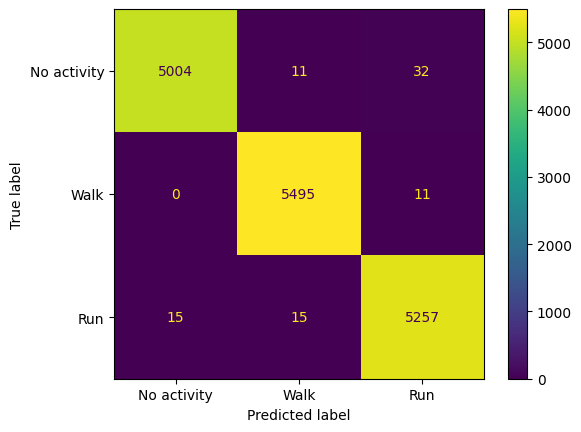

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['No activity', 'Walk', 'Run'])
disp.plot()
plt.show()

In [ ]:
model.eval()

CNN_LSTM(
  (conv): Sequential(
    (0): Conv1d(1, 16, kernel_size=(3,), stride=(1,))
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(16, 64, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ELU(alpha=1.0)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (lstm): Sequential(
    (0): LSTM(3648, 1024, batch_first=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=3, bias=True)
  )
)

# Больше тестов

In [ ]:
test_df = pd.read_csv('sample_data/8_30_05_2023_10_11_32_10_16_01_mix.csv')
test_df = test_df.drop(columns = ['time', 'pocket_id', 'v7'])
test_df = test_df.rename(columns={'v1' : 'gyro_x', 
                                  'v2' : 'gyro_y',
                                  'v3' : 'gyro_z',
                                  'v4' : 'acceleration_x',
                                  'v5' : 'acceleration_y',
                                  'v6' : 'acceleration_z'})
test_df

In [ ]:
test_df.describe()

In [ ]:
def Vizualize(df_to_vizualize, description: str):
  plt.figure(figsize = (12.8, 9.6))
  plt.grid(True)
  plt.plot(df_to_vizualize.to_numpy())
  plt.title(description)
  plt.legend(df_to_vizualize)
  plt.show()

In [ ]:
df_to_plot = test_df.drop(columns = ['gyro_x', 'gyro_y', 'gyro_z'])
Vizualize(df_to_plot, 'acceleration')

In [ ]:
df_to_plot.iloc[1600:1900].describe()

In [ ]:
df_to_plot_1 = test_df.drop(columns = ['acceleration_x', 'acceleration_y', 'acceleration_z'])
Vizualize(df_to_plot_1, 'gyro')

In [ ]:
df_to_plot_1.iloc[1600:1900].describe()

In [ ]:
names_test_df = test_df.columns
sc = scaler.transform(test_df)
scaled_test_df = pd.DataFrame(sc, columns = names_test_df)

if INPUT_DIM == 117:
  scaled_test_df = scaled_test_df.drop(columns = ['acceleration_x', 'acceleration_y', 'acceleration_z'])
  
scaled_test_df

In [ ]:
shifted_scaled_test_df = prepare_df(scaled_test_df, 38)
shifted_scaled_test_df_tensor = torch.from_numpy(shifted_scaled_test_df.to_numpy().astype(np.float32))

with torch.no_grad():
    output_test_df = model(shifted_scaled_test_df_tensor.to(device))

In [ ]:
output_test_df

In [ ]:
pred_test_df = output_test_df.argmax(dim = 1, keepdim = True)
list_pred_test_df = np.hstack(pred_test_df.cpu().numpy()).tolist()

In [ ]:
plt.figure(figsize = (12.8, 9.6))
plt.plot(list_pred_test_df)
plt.title('Predicted')
plt.show()

In [ ]:
list_true = np.concatenate(list_true)
list_true = np.hstack(list_true).tolist()

In [ ]:
# np.savetxt('test1.txt', list_pred_test_df, fmt = '%d')

# Тест 2

In [ ]:
test2_df = pd.read_csv('sample_data/data_export.csv')
test2_df = test2_df.drop(columns = ['time', 'pocket_id', 'v7'])
test2_df = test2_df.rename(columns={'v1' : 'gyro_x', 
                                  'v2' : 'gyro_y',
                                  'v3' : 'gyro_z',
                                  'v4' : 'acceleration_x',
                                  'v5' : 'acceleration_y',
                                  'v6' : 'acceleration_z'})
test2_df

In [ ]:
test2_df.describe()

In [ ]:
df2_to_plot = test2_df.drop(columns = ['gyro_x', 'gyro_y', 'gyro_z'])
Vizualize(df2_to_plot, 'acceleration')

In [ ]:
df2_to_plot.iloc[850:1150].describe()

In [ ]:
df2_to_plot_1 = test2_df.drop(columns = ['acceleration_x', 'acceleration_y', 'acceleration_z'])
Vizualize(df2_to_plot_1, 'gyro')

In [ ]:
df2_to_plot_1.iloc[850:1150].describe()

In [ ]:
df2_to_plot_1

In [ ]:
names_test2_df = test2_df.columns
sc2 = scaler.transform(test2_df)
scaled_test2_df = pd.DataFrame(sc2, columns = names_test2_df)

if INPUT_DIM == 117:
  scaled_test2_df = scaled_test2_df.drop(columns = ['acceleration_x', 'acceleration_y', 'acceleration_z'])
  
scaled_test2_df

In [ ]:
shifted_scaled_test2_df = prepare_df(scaled_test2_df, 38)
shifted_scaled_test2_df_tensor = torch.from_numpy(shifted_scaled_test2_df.to_numpy().astype(np.float32))

with torch.no_grad():
    output_test2_df = model(shifted_scaled_test2_df_tensor.to(device))

In [ ]:
output_test2_df

In [ ]:
pred_test2_df = output_test2_df.argmax(dim = 1, keepdim = True)
list_pred_test2_df = np.hstack(pred_test2_df.cpu().numpy()).tolist()

In [ ]:
plt.figure(figsize = (12.8, 9.6))
plt.plot(list_pred_test2_df)
plt.title('Predicted')
plt.show()

#Save Model

In [ ]:
 example, _ = next(iter(train_loader))
model(example.to(device))

In [ ]:
example[0]

In [ ]:
example.shape

In [ ]:
traced_script_module = torch.jit.trace(model, example.to(device))

In [ ]:
traced_script_module_optimized = optimize_for_mobile(traced_script_module)

In [ ]:
traced_script_module_optimized(example.to(device))

In [ ]:
traced_script_module_optimized._save_for_lite_interpreter('./activity_lstm_3sec_3params_2.ptl')

In [ ]:
traced_script_module_optimized(list_pred_test2_df)